In [1]:
import matplotlib.pyplot as plt 
import os
import torch
import torchaudio
from pathlib import Path
from torch.utils.data import DataLoader, Subset
import utils 
import warnings

#### Filename structure:

6229: Soundtrap#6229

22: 2022

08: August

21: Hour of day(?)

x: Iterator(?)

In [2]:
# Path setup.
root_folder = Path().resolve()
data_path = root_folder / "dryad_data" / "Aug_6229"

# Ignore userwarnings due to TorchAudio deprecating in next major release (2.9.0, late 2025).
warnings.filterwarnings("ignore", category=UserWarning)

# sample_name = "6229.220802160000.wav"
# sample_name = data_path / "6229.220802160000.wav"
sample_name = data_path / "6229.220802162000.wav"
# data_path = r"C:\Users\Lindholm\Documents\BSc\data_dryad\Aug_6229"
sample_wav = os.path.join(data_path, sample_name)

In [3]:
metadata = torchaudio.info(sample_wav)
print(metadata)

AudioMetaData(sample_rate=64000, num_frames=17278192, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [4]:
waveform, sample_rate = torchaudio.load(sample_wav)

#### Audio data:
- 64 kHz: higher resolution than common sound (16 kHz).
- 1 channel with 17 million frames.
- time = num_frames / sample_rate $\approx$ 4.5 mins.

#### Basic waveform plot
Runs very slowly because of the high resolution.

Based on https://docs.pytorch.org/audio/stable/tutorials/audio_io_tutorial.html

In [5]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_ax = torch.arange(0, num_frames) / sample_rate

    fig, ax = plt.subplots(num_channels, 1)
    ax.plot(time_ax, waveform[0], linewidth=1, color="royalblue", alpha=0.8)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    fig.suptitle("Waveform")

In [6]:
# plot_waveform(waveform, sample_rate)

#### Faster waveform plot
Only works for mono-channel audio.

In [7]:
def plot_waveform_fast(waveform, sample_rate, max_pts:int=30_000, title:str="Waveform", ax=None):
    n_channels, n_frames = waveform.shape
    # Truncation steps only for visualizing waveforms.
    stride = max(1, n_frames // max_pts) 
    wf_visual = waveform[:, ::stride]
    # Time in seconds: time = frames / sample_rate and strides are frames divided by steps.  
    t = torch.arange(wf_visual.shape[1], dtype=torch.float32) * (stride / sample_rate) 

    wf_visual = wf_visual.cpu().numpy()
    t = t.cpu().numpy()

    if ax is None: 
        fig, ax = plt.subplots(figsize=(10, 3))
    else: 
        fig = None

    ax.plot(t, wf_visual[0], linewidth=1, color="royalblue", alpha=0.8)
    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    
    return fig, ax 

(<Figure size 1000x300 with 1 Axes>,
 <Axes: title={'center': 'Waveform'}, xlabel='Time (seconds)', ylabel='Amplitude'>)

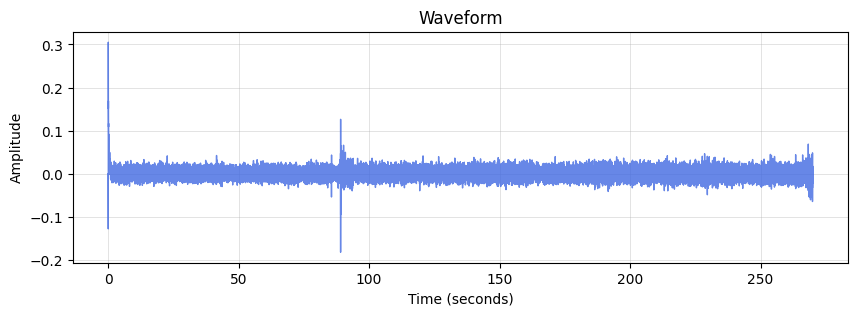

In [8]:
plot_waveform_fast(waveform, sample_rate)

#### Data loader
Based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [9]:
start_idx = 8 # Create a data subset to skip noise waveforms.
dataset = utils.AudioDataset(data_path, target_sr=sample_rate, max_secs=None)
subset = Subset(dataset, range(start_idx, len(dataset)))
loader = DataLoader(subset, batch_size=1, shuffle=False) # Only shuffle data when training.

Manually checked data subset up to index $=9 \cdot 40$.

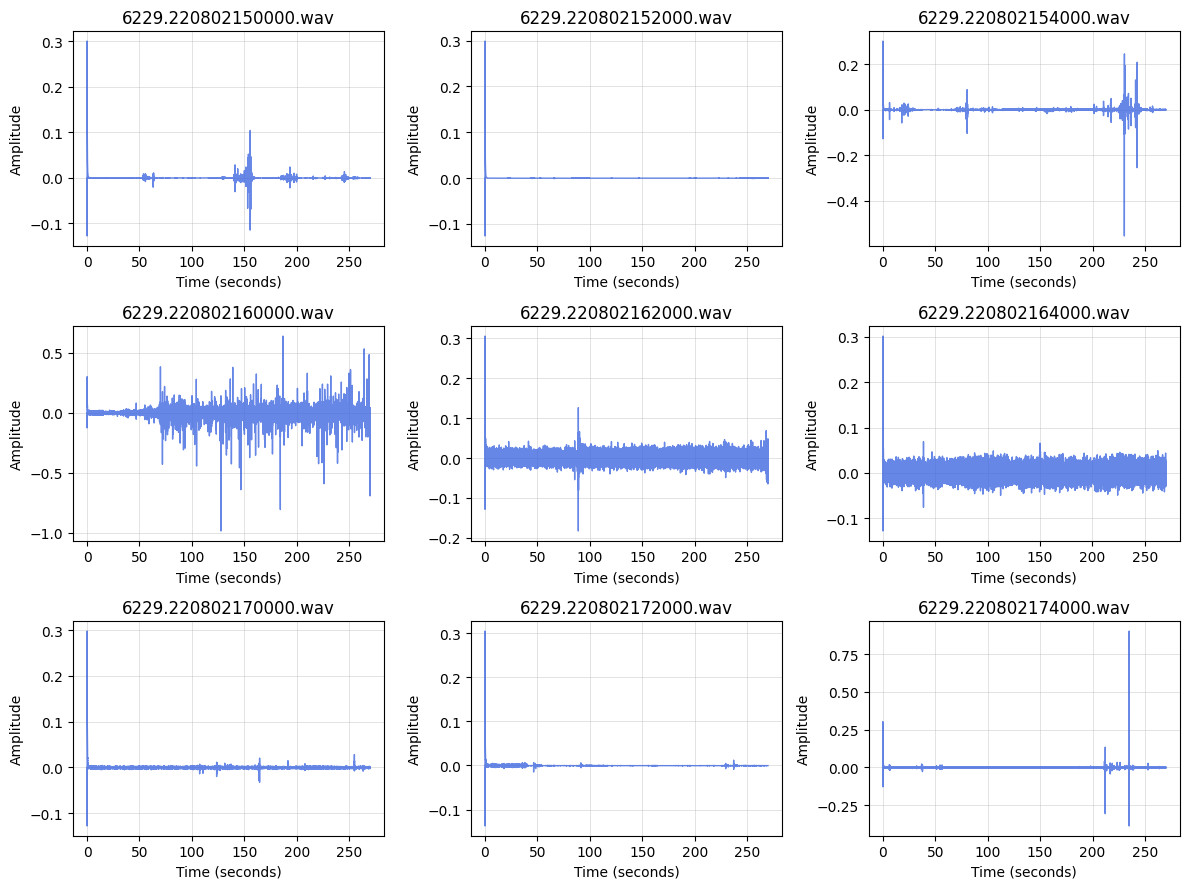

In [10]:
max_points = 30_000
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
axes = axes.flatten()

file_list = []
i = 0
for waves, srs, paths in loader:
    for w, sr, path in zip(waves, srs, paths):
        p = Path(path).name
        plot_waveform_fast(w, sr, max_points, title=p, ax=axes[i])
        file_list.append(p)

        i += 1
    if i >= rows*cols:
        break

plt.tight_layout()
plt.show()

### Notes
- Every .wav file seems to begin with 1 second of noise.

#### Notable files
'6229.220802160000.wav', '6229.220802162000.wav', '6229.220802164000.wav', '6229.220804080000.wav', '6229.220805090000.wav', '6229.220805094000.wav', '6229.220805100000.wav', '6229.220805102000.wav', '6229.220805104000.wav', '6229.220805110000.wav', '6229.220805112000.wav', '6229.220805114000.wav', '6229.220806052000.wav', '6229.220806184000.wav'

#### Find interesting waveforms with high amplitudes.

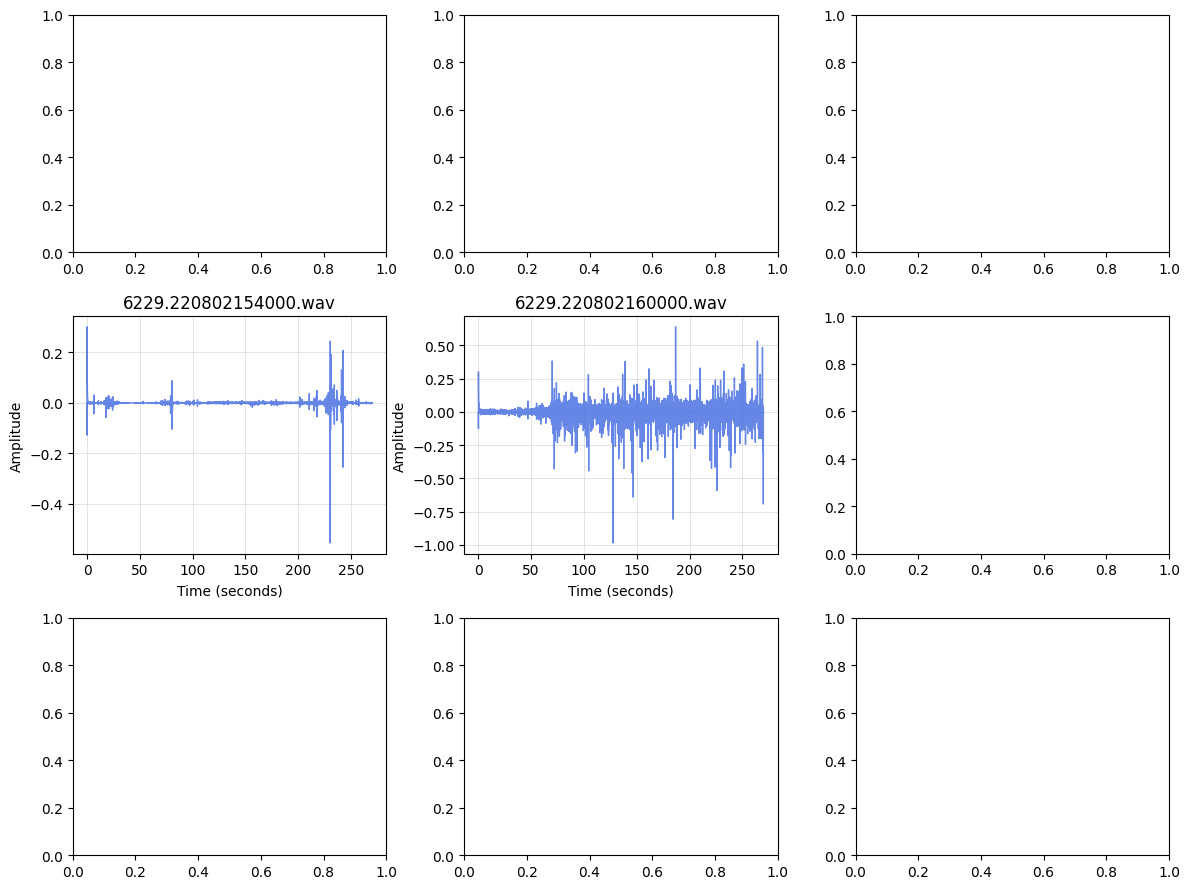

In [11]:
s_idx = int(3 * sample_rate)
max_iter = 10
ampl_threshold = 0.3
ampl_frac = 10e-6
wave_list = []

max_points = 30_000
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
axes = axes.flatten()

i = 0
for waves, srs, paths in loader:
    if len(wave_list) >= max_iter:
        break
    for w, sr, path in zip(waves, srs, paths):
        waveclip = w[0, s_idx:] # Exclude the first corrupted seconds of every recording.
        wavepeak = float(waveclip.abs().max().item())
        wavefrac = float((waveclip.abs() >= ampl_threshold).float().mean().item())
        i += 1
        if wavepeak >= ampl_threshold and wavefrac >= ampl_frac:
            p = Path(path).name
            wave_list.append((w, sr, path))
            if i >= rows*cols:
                break
            plot_waveform_fast(w, sr, max_points, title=p, ax=axes[i])

plt.tight_layout()
plt.show()

#### Spectrograms

In [12]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    n_channels, n_frames = waveform.shape
    wf = waveform.numpy()

    fig, ax = plt.subplots(n_channels, 1, figsize=(7,6))
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Frequency")
    ax.specgram(wf[0], Fs=sample_rate)
    fig.suptitle(title)

In [13]:
# sample_name = '6229.220806184000.wav'
# sample_name = "6229.220802162000.wav"
sample_name = "6229.220802160000.wav"
sample_wav = os.path.join(data_path, sample_name)

In [14]:
waveform, sample_rate = torchaudio.load(sample_wav)

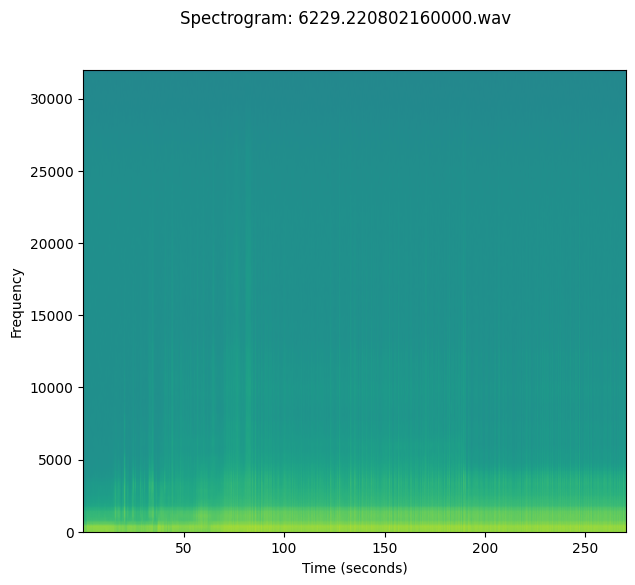

In [15]:
plot_specgram(waveform, sample_rate, title=r"Spectrogram: " + sample_name)

#### Spectrograms
- x-axis: time (seconds).
- y-axis: magnitude of the frequency spectrum calculated using Fourier transform. 
- Frequency: the number of occurring mechanical waves of pressure (the definition of sound) per unit of time. 